In [88]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import rfpimp
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline, make_union
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.metrics import (accuracy_score,
                             roc_auc_score,
                             confusion_matrix,
                             classification_report,
                             make_scorer)
from sklearn.model_selection import (train_test_split,
                                     cross_val_score,
                                     KFold,
                                     StratifiedKFold,
                                     learning_curve,
                                     validation_curve,
                                     GridSearchCV,
                                     RandomizedSearchCV)
from sklearn.feature_selection import SelectFromModel, SelectKBest

import utils

%matplotlib inline
sns.set_context('notebook')
plt.style.use('fivethirtyeight')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
data = pd.read_csv('data/parole.csv', low_memory=False)
data.head()

,male,race,age,state,time.served,max.sentence,multiple.offenses,crime,violator
0,1,1,33.2,1,5.5,18,0,4,0
1,0,1,39.7,1,5.4,12,0,3,0
2,1,2,29.5,1,5.6,12,0,3,0
3,1,1,22.4,1,5.7,18,0,1,0
4,1,2,21.6,1,5.4,12,0,1,0


In [59]:
# Add random feature
data['random'] = np.random.random(data.shape[0])
data.head()

,male,race,age,state,time.served,max.sentence,multiple.offenses,crime,violator,random
0,1,1,33.2,1,5.5,18,0,4,0,0.566672
1,0,1,39.7,1,5.4,12,0,3,0,0.115158
2,1,2,29.5,1,5.6,12,0,3,0,0.350335
3,1,1,22.4,1,5.7,18,0,1,0,0.526150
4,1,2,21.6,1,5.4,12,0,1,0,0.920031


In [64]:
# Convert to numpy
X = data.drop(['violator'], axis=1).values
y = data['violator'].values
print(f'Shape : {X.shape}, {y.shape}')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)
print(f'Training : {X_train.shape}')
print(f'Test : {X_test.shape}')

Shape : (675, 9), (675,)
Training : (472, 9)
Test : (203, 9)


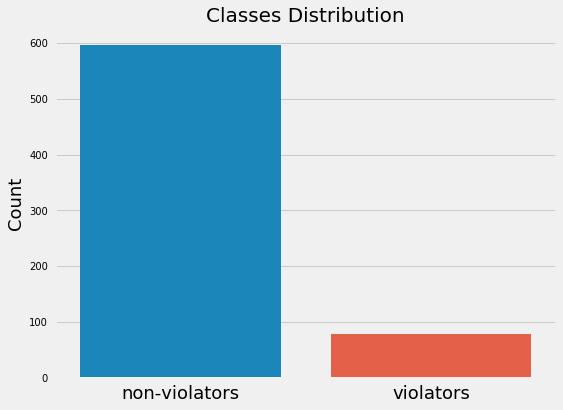

In [65]:
# Plot class distribution
utils.plot_class_dist(y, ['non-violators', 'violators'])

In [66]:
pca = PCA(n_components=None, svd_solver="full")
pca.fit(StandardScaler().fit_transform(X_train))

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='full', tol=0.0, whiten=False)

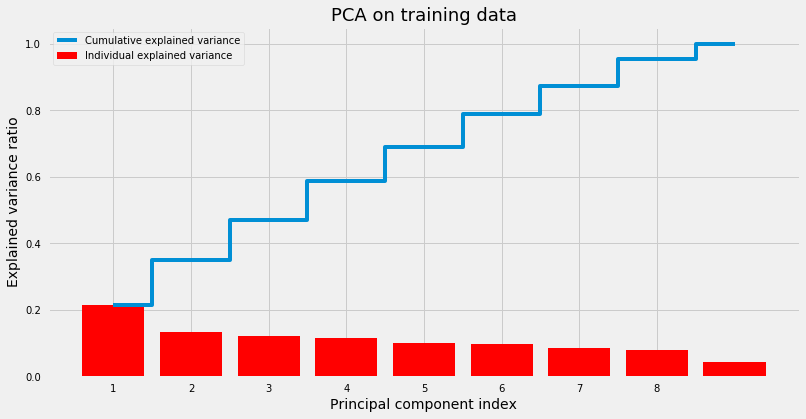

In [67]:
utils.plot_pca_var_explained(pca)

In [68]:
# Create dummy classifier
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train, y_train)
print(f'Training accuracy : {accuracy_score(y_train, dummy_clf.predict(X_train)):.2%}')
print(f'Training AUC : {roc_auc_score(y_train, dummy_clf.predict(X_train)):.2%}')

Training accuracy : 88.35%
Training AUC : 50.00%


In [69]:
# Create CV object
kf = StratifiedKFold(5, shuffle=True, random_state=1)

In [83]:
features = np.concatenate([data.columns[:-2], data.columns[-1:]])
features

array(['male', 'race', 'age', 'state', 'time.served', 'max.sentence',
       'multiple.offenses', 'crime', 'random'], dtype=object)

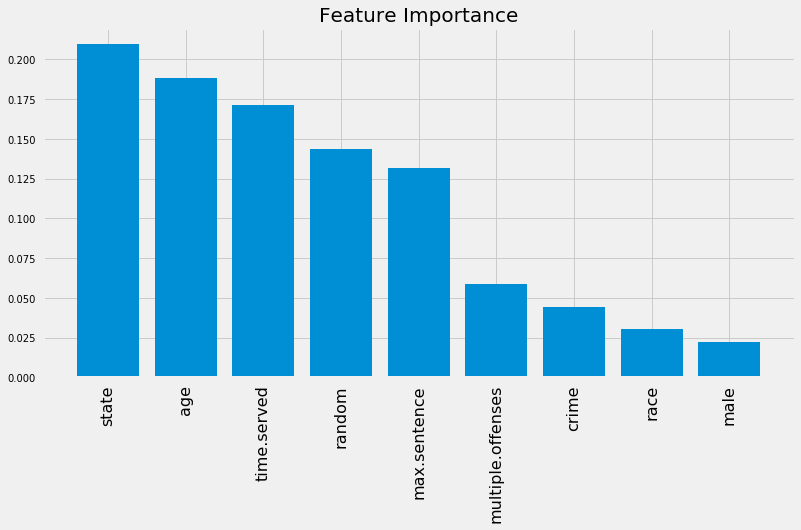

In [84]:
rf_clf = RandomForestClassifier(n_estimators=100,
                                class_weight='balanced',
                                random_state=1,
                                oob_score=True)
rf_clf.fit(X_train, y_train)
utils.plot_feature_imp(rf_clf, feature_names=features)

In [86]:
1 / np.exp(1) - 1

-0.6321205588285577

In [87]:
np.random.permutation(10)

array([8, 1, 2, 7, 9, 3, 4, 0, 6, 5])

In [90]:
_generate_unsampled_indices??

In [ ]:
np.bincount()

In [91]:
rf_clf.classes_

array([0, 1])

In [93]:
def oob_accuracy(rf_clf, X_train, y_train):
    n_samples = X_train.shape[0]
    n_classes = len(np.bincount(y_train))
    preds_matrix = np.zeros((n_samples, n_classes))
    
    # Iterate over all trees
    for tree in rf_clf.estimators_:
        # Generate unsampled indices
        unsampled_idxs = _generate_unsampled_indices(tree.random_state, n_samples)
        preds = tree.predict_proba(X_train[unsampled_idxs, :])
        preds_matrix[unsampled_idxs, :] += preds
    
    preds_classes = np.argmax(preds_matrix, axis=1)
    oob_score = (y_train == preds_classes).mean()
    return oob_score

def permutation_importances(rf_clf, X_train, y_train, scorer):
    feat_imp = []
    baseline_score = scorer(rf_clf, X_train, y_train)
    for j in range(X_train.shape[1]):
        temp = X_train[:, j].copy()
        X_train[:, j] = np.random.permutation(X_train[:, j])
        score = scorer(rf_clf, X_train, y_train)
        feat_imp.append(baseline_score - score)
        X_train[:, j] = temp
    return np.array(feat_imp)

In [112]:
oob_accuracy(rf_clf, X_train, y_train)

0.8792372881355932

In [113]:
perm_imp = permutation_importances(rf_clf, X_train, y_train, oob_accuracy)

In [114]:
perm_imp

array([-0.00211864,  0.        ,  0.01483051,  0.00847458,  0.        ,
       -0.00423729,  0.01271186, -0.00635593, -0.01059322])

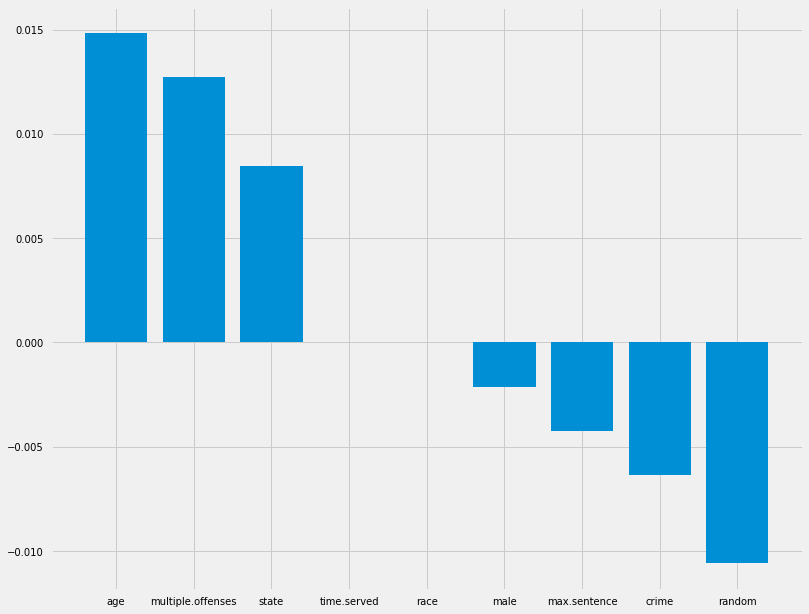

In [116]:
idxs = np.argsort(perm_imp)[::-1]
plt.figure(figsize=(12, 10))
plt.bar(range(9), perm_imp[idxs])
plt.xticks(range(9), features[idxs]);

In [110]:
np.array(perm_imp)[idxs]

array([ 0.01059322,  0.00635593,  0.00211864,  0.00211864,  0.00211864,
        0.00211864,  0.        , -0.00423729, -0.00847458])

In [117]:
features

array(['male', 'race', 'age', 'state', 'time.served', 'max.sentence',
       'multiple.offenses', 'crime', 'random'], dtype=object)

In [119]:
cross_val_score(rf_clf, X_train, y_train, scoring='roc_auc', cv=kf, n_jobs=-1).mean()

0.844753038126532

In [120]:
rf_clf = RandomForestClassifier(n_estimators=100,
                                class_weight='balanced',
                                random_state=1,
                                oob_score=True)
cross_val_score(rf_clf, X_train[:, [2, 3, 6]], y_train, scoring='roc_auc', cv=kf, n_jobs=-1).mean()

0.7672768998070202

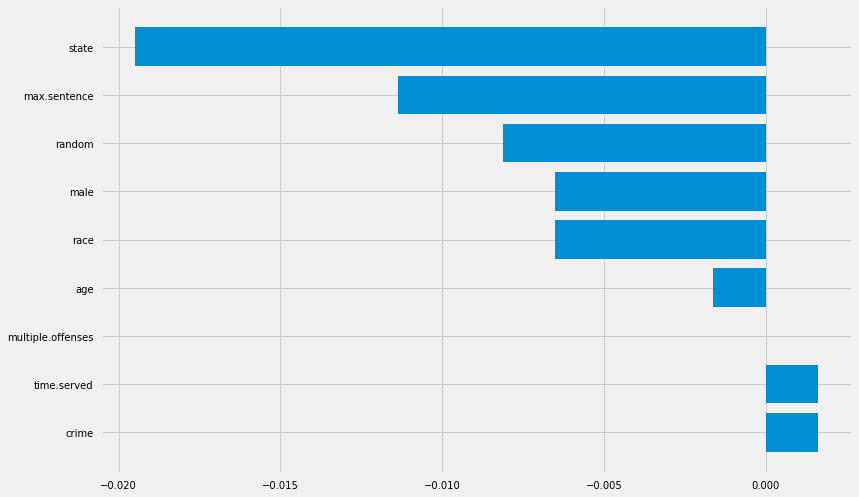

In [137]:
idxs = np.argsort(perm_imp)[::-1]
plt.figure(figsize=(12, 8))
plt.barh(range(9), perm_imp[idxs])
plt.yticks(range(9), features[idxs]);

In [139]:
df = pd.read_csv('data/rent.txt')
df.shape

(49352, 6)

In [140]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.base import clone

import warnings
warnings.filterwarnings('ignore')

def mkdf(columns, importances):
    I = pd.DataFrame(data={'Feature':columns, 'Importance':importances})
    I = I.set_index('Feature')
    I = I.sort_values('Importance', ascending=True)
    return I

def plot_importances(df_importances, save=None, xrot=0, tickstep=3, scalefig=(1.0,1.0)):
    """
    Given an array or data frame of importances, plot a horizontal bar chart
    showing the importance values.
    """
    I = df_importances

    fig = plt.figure()
    w, h = fig.get_size_inches()
    fig.set_size_inches(w*scalefig[0], h*scalefig[1], forward=True)
    ax = plt.gca()
    ax.barh(np.arange(len(I.index)), I.Importance, height=.7, tick_label=I.index)

    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    ax.set_aspect((x1 - x0) / (y1 - y0))

    # rotate x-ticks
    if xrot is not None:
        plt.xticks(rotation=xrot)

    # xticks freq
    xticks = ax.get_xticks()
    nticks = len(xticks)
    new_ticks = xticks[np.arange(0, nticks, step=tickstep)]
    ax.set_xticks(new_ticks)

    plt.tight_layout()
    if save:
        plt.savefig(save, bbox_inches="tight", pad_inches=0.03)
    plt.show()

In [162]:
df = pd.read_csv("data/rent.txt")
features = ['bathrooms','bedrooms','price','longitude','latitude',
            'interest_level']
df = df[features].copy()
df.to_csv("data/rent-numeric.csv", index=False)
df.head(5)

,bathrooms,bedrooms,price,longitude,latitude,interest_level
0,1.5,3,3000,-73.9425,40.7145,2
1,1.0,2,5465,-73.9667,40.7947,1
2,1.0,1,2850,-74.0018,40.7388,3
3,1.0,1,3275,-73.9677,40.7539,1
4,1.0,4,3350,-73.9493,40.8241,1


0.716424866266818


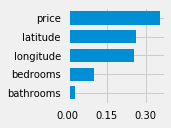

0.7132436375425515


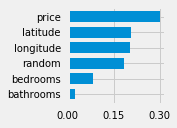

In [146]:
base_rf = RandomForestClassifier(n_estimators=100,
                                 min_samples_leaf=5,
                                 n_jobs=-1,
                                 oob_score=True)

X_train, y_train = df.drop('interest_level',axis=1), df['interest_level']

rf = clone(base_rf)
rf.fit(X_train, y_train)
print(rf.oob_score_)
I = mkdf(X_train.columns,rf.feature_importances_)            
plot_importances(I, scalefig=(1.0,0.5))

X_train2 = X_train.copy()
X_train2['random'] = np.random.random(size=len(X_train2))
rf2 = clone(base_rf)
rf2.fit(X_train2, y_train)
print(rf2.oob_score_)
I = mkdf(X_train2.columns,rf2.feature_importances_)
plot_importances(I, scalefig=(1.0,0.5))

In [164]:
from sklearn.ensemble.forest import _generate_unsampled_indices

# TODO: add arg for subsample size to compute oob score

def oob_classifier_accuracy(rf, X_train, y_train):
    X = X_train.values
    y = y_train.values

    n_samples = len(X)
    n_classes = len(np.unique(y))
    predictions = np.zeros((n_samples, n_classes))
    for tree in rf.estimators_:
        unsampled_indices = _generate_unsampled_indices(tree.random_state, n_samples)
        tree_preds = tree.predict_proba(X[unsampled_indices, :])
        predictions[unsampled_indices] += tree_preds

    predicted_class_indexes = np.argmax(predictions, axis=1)
    predicted_classes = [rf.classes_[i] for i in predicted_class_indexes]

    oob_score = np.mean(y == predicted_classes)
    return oob_score

def permutation_importances(rf, X_train, y_train, metric):
    """
    Return importances from pre-fit rf; metric is function
    that measures accuracy or R^2 or similar. This function
    works for regressors and classifiers.
    """
    baseline = metric(rf, X_train, y_train)
    imp = []
    for col in X_train.columns:
        save = X_train[col].copy()
        X_train[col] = np.random.permutation(X_train[col])
        m = metric(rf, X_train, y_train)
        X_train[col] = save
        imp.append(baseline - m)
    return np.array(imp)

In [165]:
X_train, y_train = df.drop('interest_level',axis=1), df['interest_level']
rf = clone(base_rf)
rf.fit(X_train, y_train)
oob = oob_classifier_accuracy(rf, X_train, y_train)
print("oob accuracy",oob)

imp = permutation_importances(rf, X_train, y_train,
                              oob_classifier_accuracy)
imp

oob accuracy 0.7180863997406387


array([0.00419436, 0.09559896, 0.14232453, 0.03242017, 0.03355487])

oob accuracy 0.7171543199870319


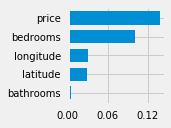

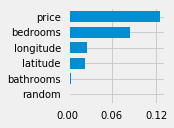

In [149]:
I = mkdf(X_train.columns,imp)
plot_importances(I, scalefig=(1.0,0.5))

X_train2 = X_train.copy()
X_train2['random'] = np.random.random(size=len(X_train))
rf2 = clone(base_rf)
rf2.fit(X_train2, y_train)

imp = permutation_importances(rf2, X_train2, y_train,
                            oob_classifier_accuracy)
I = mkdf(X_train2.columns,imp)
plot_importances(I, scalefig=(1.0,0.5))

In [169]:
def oob_accuracy(rf_clf, X_train, y_train):
    n_samples = X_train.shape[0]
    n_classes = len(np.bincount(y_train))
    preds_matrix = np.zeros((n_samples, n_classes))
    
    # Iterate over all trees
    for tree in rf_clf.estimators_:
        # Generate unsampled indices
        unsampled_idxs = _generate_unsampled_indices(tree.random_state, n_samples)
        preds = tree.predict_proba(X_train[unsampled_idxs, :])
        preds_matrix[unsampled_idxs, :] += preds
    
    preds_classes = np.argmax(preds_matrix, axis=1)
    oob_score = (y_train == preds_classes).mean()
    return oob_score

def permutation_importances(rf_clf, X_train, y_train, scorer):
    feat_imp = []
    baseline_score = scorer(rf_clf, X_train, y_train)
    for j in range(X_train.shape[1]):
        temp = X_train[:, j].copy()
        X_train[:, j] = np.random.permutation(X_train[:, j])
        score = scorer(rf_clf, X_train, y_train)
        feat_imp.append(baseline_score - score)
        X_train[:, j] = temp
    return np.array(feat_imp)

In [170]:
# Convert to numpy
X_train = df.drop(['interest_level'], axis=1).values
y_train = df['interest_level'].values
y_train = pd.Series(y_train).map({1: 0, 2: 1, 3: 2}).values
print(f'Shape : {X_train.shape}, {y_train.shape}')

Shape : (49352, 5), (49352,)


In [171]:
base_rf = RandomForestClassifier(n_estimators=100,
                                 min_samples_leaf=5,
                                 n_jobs=-1,
                                 oob_score=True)
rf_clf = clone(base_rf)
rf_clf.fit(X_train, y_train)
oob = oob_accuracy(rf_clf, X_train, y_train)
print("oob accuracy",oob)

imp = permutation_importances(rf_clf, X_train, y_train,
                              oob_accuracy)

oob accuracy 0.7177824606905495


In [172]:
imp

array([0.00382963, 0.10165748, 0.14175717, 0.03363592, 0.03250122])

In [156]:
np.unique(pd.Series(y_train).map({1: 0, 2: 1, 3: 2}))

array([0, 1, 2])

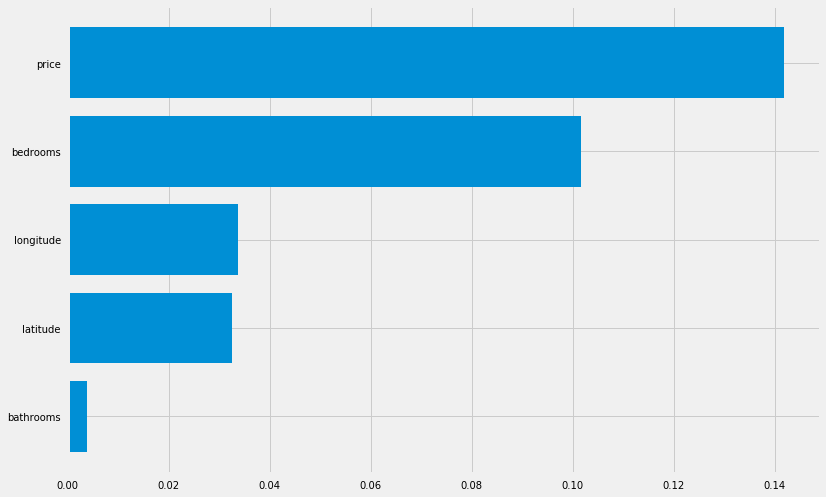

In [180]:
idxs = np.argsort(imp)
plt.figure(figsize=(12, 8))
plt.barh(range(5), imp[idxs])
plt.yticks(range(5), df.columns[:-1][idxs]);